# Assignment One

CS529

Adrien Clay

Refat Mishuk

Christopher Jarek

Thomas Hynes

In [195]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from perceptron import Perceptron
from perceptron_ab import PerceptronAbsorbedBias
from adaline_gd import AdalineGD
from multiclass_perceptron import MulticlassPerceptron
from adaline_sgd import AdalineSGD
from helpers import plot_decision_regions
import numpy as np
import os
%matplotlib inline

# Define global constants

RANDOM_STATE = 42
EPOCHS = 10
LEARNING_RATE = 0.01
OUTPUT_DIR = 'report_graphs'
REDUCED_FEATURE_VECTOR = ['sepal length (cm)', 'petal length (cm)']

try:
    os.mkdir(OUTPUT_DIR)
except:
    pass

In [196]:
# Load Data
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

## 1. Binary Classification differences between Perceptron & Adaline Models

- This section will highlight the differences between the Perceptron & Adaline models from the textbook
- The data will only use two classes, dropping the remaining class for now so it is a binary classification problem
-   We will use sepal length & petal length

### 1.1 Data preprocessing

1. Filter out 3rd unused target class
2. Get full X & y arrays from both features and target values respectively

In [197]:
# Instantiate and train models
binary_df = df[df['target'] != 2]
print(f"Length of data with only two classes: {len(binary_df)}")

# We should only have 2 classes now. Stop execution if not
assert len(binary_df['target'].unique()) == 2

# Get feature values
X = binary_df[REDUCED_FEATURE_VECTOR].values
y = binary_df['target'].values

Length of data with only two classes: 100


### 1.2 Train Models

1. Train Perceptron
2. Train Adaline
3. Display differences in error and margin

In [198]:
pnn = Perceptron(eta=LEARNING_RATE, n_iter=EPOCHS, random_state=RANDOM_STATE)

ada_gd = AdalineGD(eta=LEARNING_RATE, n_iter=EPOCHS, random_state=RANDOM_STATE)

#pnn.fit(X_train, y_train)
pnn.fit(X, y)

#ada_gd.fit(X_train, y_train)
ada_gd.fit(X, y)

print('Number of updates in Perceptron:',pnn.n_iter-pnn.errors_.count(0))
margin=abs(np.min((np.dot(X, pnn.w_)+pnn.b_)/np.linalg.norm(pnn.w_)))
print('Perceptron Margin:',margin)
print('For Perceptron converged in weight ',pnn.w_,' & bias ',pnn.b_)
print()
print('Number of updates in AdalineGD:',ada_gd.n_iter-ada_gd.losses_.count(0))
margin=abs(np.min((np.dot(X, ada_gd.w_)+ada_gd.b_)/np.linalg.norm(ada_gd.w_)))
print('AdalineGD Margin:',margin)
print('For AdalineGD converged in weight ',ada_gd.w_,' & bias ',ada_gd.b_)

Number of updates in Perceptron: 5
Perceptron Margin: 1.4714216384428058
For Perceptron converged in weight  [-0.03803286  0.08561736]  & bias  -0.02

Number of updates in AdalineGD: 10
AdalineGD Margin: 2.6922226636562887
For AdalineGD converged in weight  [0.0448985  0.10684578]  & bias  0.0014240643557286022


### 1.3 Compare Errors/Loss over the training intervals (epochs)

#### Loss function

In Perceptron learning, Loss is calculated as $$\sum_{n=1}^{n=100}{(y_i - y\hat{i})} $$

In Adaline, loss is calculated as $$\frac{1}{n}\sum_{n=1}^{n=100}{(y_i - \hat{y}_i)^2} $$

#### Number of updates

Number of updates = Number of iteration - Number of non-zero loss function. 
In perceptron number of nonzero loss function is 5, resulting number of updates: $10 - 5 = 5$

In case of Adaline, there is no nonzero loss function resulting number of update: $10 - 0 = 10$

#### Margin

The margin refers to the distance between the decision boundary and the nearest data point. A larger margin typically indicates better generalization.
So, margin is calculated as $$\min {\frac{W^Tx+b}{|W|}}$$
In case of Perceptron, $$W=W_j+\Delta W_j=W_j+\eta(y_i-\hat{y}_i)x_j$$ So, The Perceptron does not try to find the decision boundary that maximizes the margin.

In case of Adaline, $$ W=W_j+\Delta W_j=W_j-\eta\frac{\partial L}{\partial W_j} $$ As Adaline directly minimizes the error across all data points, the margin is higher.

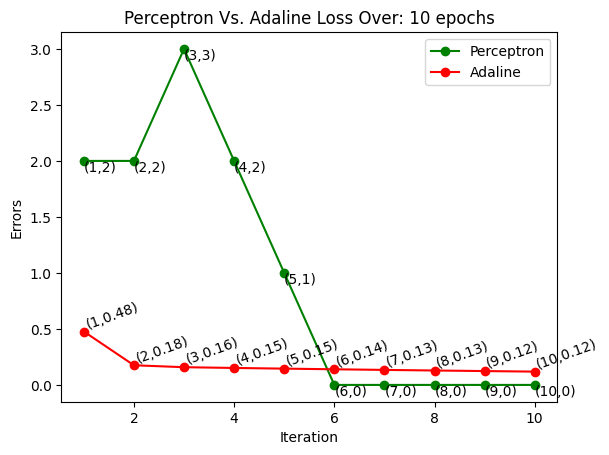

<Figure size 640x480 with 0 Axes>

In [199]:
plt.plot(range(1, len(pnn.errors_)+1), pnn.errors_, marker = 'o', label="Perceptron", color="green")
plt.plot(range(1, len(ada_gd.losses_)+1), ada_gd.losses_, marker = 'o', label="Adaline", color="red")

for x_, y_ in zip(range(1, len(pnn.errors_)+1), pnn.errors_):
    plt.text(x_, y_, "({},{})".format(x_,y_), va='top')

for x_, y_ in zip(range(1, len(ada_gd.losses_)+1), ada_gd.losses_):
    plt.text(x_, y_, "({},{:.2f})".format(x_,y_), va="bottom", rotation=20)

plt.title(f"Perceptron Vs. Adaline Loss Over: {EPOCHS} epochs")
plt.xlabel("Iteration")
plt.ylabel("Errors")
plt.legend()
plt.show()
plt.savefig(f"./{OUTPUT_DIR}/PNN_Errors.png")

### 1.4 Compare Decision boundaries to get a feel for difference in margin

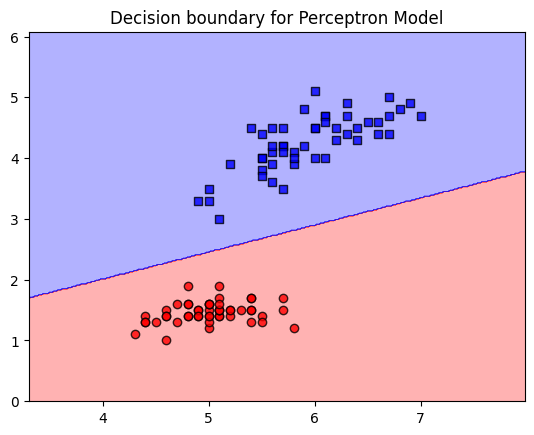

In [200]:
plot_decision_regions(X, y, pnn)
plt.title("Decision boundary for Perceptron Model")
plt.savefig(f"./{OUTPUT_DIR}/PNN_DecisionBoundary.png")

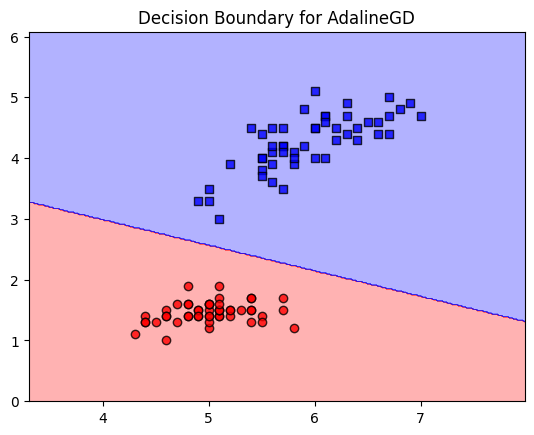

In [201]:
plot_decision_regions(X, y, ada_gd)
plt.title("Decision Boundary for AdalineGD")
plt.savefig(f"./{OUTPUT_DIR}/AdaDecisionBoundary.png")


\pagebreak

## 2. Perceptron with Absorbed Bias

- Add an extra dimension to the weight vector that includes the bias
- Add an extra feature that is always one to the input features

- The approach to make this work is as follows:

$$[w_1, w_2, w_3, ... w_n, b]$$
$$[x_1, x_2, x_3, ... x_n, 1]$$

To make this work, the modified code in `perceptron_ab.py` can be written as:


```python
# From fit function
# intialize the weights with an extra by adding one to the shape
self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1] + 1)
# Add a 1 to each feature vector
X_new = [np.append(x, 1) for x in X]
```

In [202]:
pn_ab = PerceptronAbsorbedBias(eta=LEARNING_RATE, n_iter=EPOCHS,random_state=RANDOM_STATE)

pn_ab.fit(X, y)

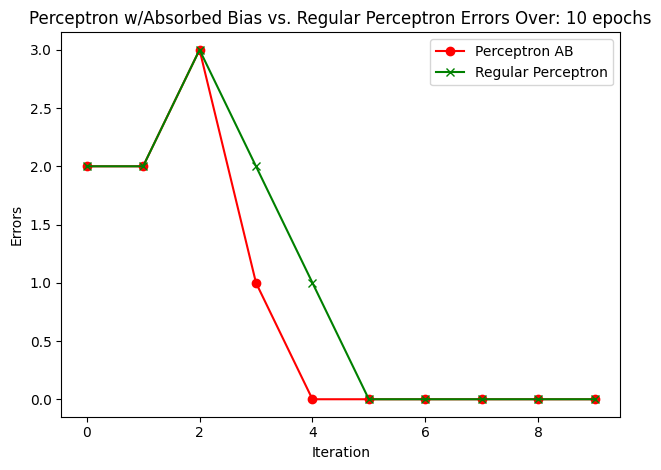

<Figure size 640x480 with 0 Axes>

In [203]:
plt.plot(pn_ab.errors_, label="Perceptron AB", color='red', marker='o')
plt.plot(pnn.errors_, label='Regular Perceptron', color='green', marker='x')
plt.title(f"Perceptron w/Absorbed Bias vs. Regular Perceptron Errors Over: {EPOCHS} epochs")
plt.xlabel("Iteration")
plt.ylabel("Errors")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(f"./{OUTPUT_DIR}/Perceptron_absorbed_Bias.png")

\pagebreak

## 3. Multiclass Perceptron

The multiclass perceptron can be implemented using a technique known as 'One vs. Rest' as described in [this article](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/). For each target class in the data, create a new model that treats it as a positive label and treat all other classes combined as a negative label. The following table shows how each set of classes will be treated in relation to the target class in the Iris dataset:
<center>

| Target  | Rest  |
|---|-------|
| 0 | [1,2] |
| 1 | [0,2] |
| 2 | [0,1] |

</center>


The `MultiClassPerceptron` class takes the input array and derives the unique targets from $y$ as a set, and loops over each unique target, replacing the target class in $y$ with $1$ and all other classes with $0$ resulting in a binary classifiation problem. A perceptron model is then instantiated and trained on this problem for each class in the set $y$. In our implementation, the first model to produce a $1$ is chosen as the prediction. This introduces some severe shortcomings that are not clear on how to handle or, at the very least, may not be something we're able to handle until later in the semester. Some research shows that there are formal/offical methods $^1$ for selecting the prediction from an ensemble of models, however, this requires the predictions to be in the form of probabilities such that the model that predicts the highest probability of class membership will be chosen as the class prediction.

Since our model is a naive implementation, it will simply choose the first $1$ prediction that is found. If all models return a $0$, it will simply default to target class $1$. This introduces randomness to the process, and as such the model results are unreliable and highly varying across runs, especially if a `random_state` value is not provided. This is a situation in which an implementation of `predict_proba` would be appropriate, just like the function found in many Scikit-Learn models. In general, the model appears to perform between 67% at the lowest and 100% at the highest with no consistency.



<br></br>


> $^1$ See [Platt Scaling](https://www.geeksforgeeks.org/understanding-the-predictproba-function-in-scikit-learns-svc/#internal-mechanism-platt-scaling), an internal mechanism of sklearn's `predict_proba` function in SVM's

In [204]:
# Redefine X, y and corresponding training vectors to include all features and all 3 classes in the iris dataset
X = df.drop('target', axis=1).values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [205]:
mp = MulticlassPerceptron(eta=LEARNING_RATE, n_iter=EPOCHS, random_state=RANDOM_STATE, model="perceptron")
mp.fit(X_train, y_train)
preds = mp.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.87      0.93        15
           2       0.88      1.00      0.94        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



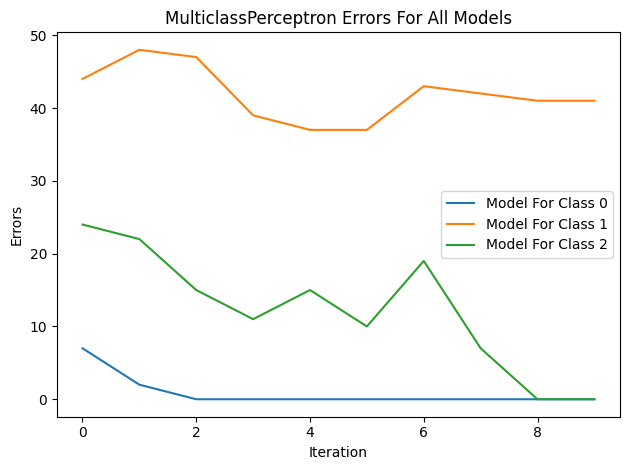

<Figure size 640x480 with 0 Axes>

In [206]:
for target_class, errors in mp.errors_.items():
    plt.plot(errors, label=f"Model For Class {target_class}")
plt.title("MulticlassPerceptron Errors For All Models")
plt.xlabel("Iteration")
plt.ylabel("Errors")
plt.tight_layout()
plt.legend()
plt.show()
plt.savefig(f"./{OUTPUT_DIR}/mp_combined_errors.png")

\pagebreak

## 4. Mini-Batch Gradient Descent w/Adaline

- Shuffle data according to a batch size
- Implementation in `AdalineSGD`, using a new function `fit_mini_batch_SGD`
- This function takes a parameter `batch_size` that provides random permutations of the input X and y vectors

The result shown below shows that the loss of the mini-batch implemenation starts very low.

When graphed against the other Adaline models, it appears to minimize at about the same rate, the resulting loss is surprisingly low.

In [207]:
# Redefine X and y to the reduced feature vector again
# Redefine from the binary_df that already has only two class labels
X = binary_df[REDUCED_FEATURE_VECTOR].values
y = binary_df['target'].values

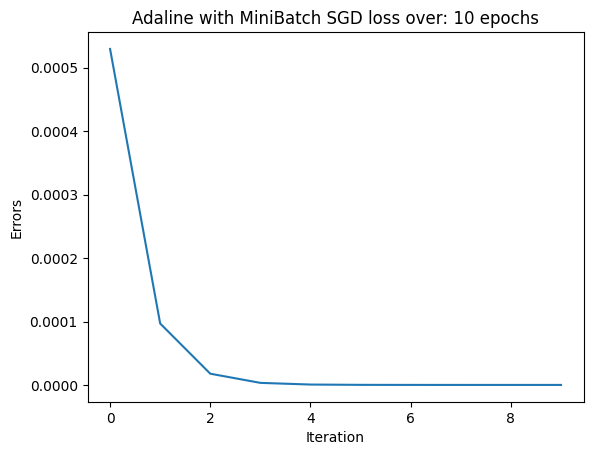

<Figure size 640x480 with 0 Axes>

In [208]:
# Fit both a MiniBatch implementation and a regular SGD implementation
ada_mini = AdalineSGD(eta=LEARNING_RATE, n_iter=EPOCHS, random_state=RANDOM_STATE)
ada_mini.fit_mini_batch_SGD(X, y, batch_size=32)

ada_sgd = AdalineSGD(eta=LEARNING_RATE, n_iter=EPOCHS, random_state=RANDOM_STATE)
ada_sgd.fit(X, y)

plt.plot(ada_mini.losses_)
plt.title(f"Adaline with MiniBatch SGD loss over: {EPOCHS} epochs")
plt.xlabel("Iteration")
plt.ylabel("Errors")
plt.show()
plt.savefig(f"./{OUTPUT_DIR}/ada_mini_losses.png")

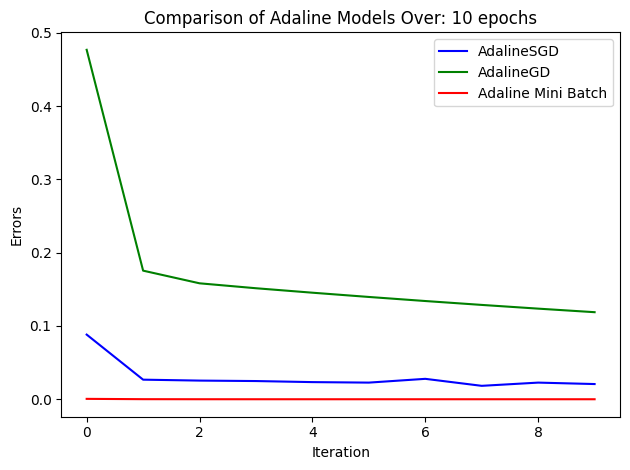

<Figure size 640x480 with 0 Axes>

In [209]:
plt.plot(ada_sgd.losses_, color="blue", label="AdalineSGD")
plt.plot(ada_gd.losses_, color="green", label="AdalineGD")
plt.plot(ada_mini.losses_, color='red', label="Adaline Mini Batch")
plt.title(f"Comparison of Adaline Models Over: {EPOCHS} epochs")
plt.xlabel("Iteration")
plt.ylabel("Errors")
plt.tight_layout()
plt.legend()
plt.show()
plt.savefig(f"./{OUTPUT_DIR}/ada_sgd_losses.png")

In [210]:
print(f"Adaline final loss value after {EPOCHS} epochs: {ada_gd.losses_[-1]}")
print(f"AdalineSGD final loss value after {EPOCHS} epochs: {ada_sgd.losses_[-1]}")
print(f"AdalineMBGD (Mini-Batch) final loss value after {EPOCHS} epochs: {ada_mini.losses_[-1]}")

Adaline final loss value after 10 epochs: 0.11881986493371728
AdalineSGD final loss value after 10 epochs: 0.020748373986240673
AdalineMBGD (Mini-Batch) final loss value after 10 epochs: 2.431404080852273e-07
